In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from scipy.stats import f_oneway

# LOAD THE FILE INTO DATAFRAME.
* WeekDay and Hours are created from `calc_created`
* Keep top 6 of driver/rider app version, the rest is grouped into `Others`
* Similarly, keep top 30 of `device_name`, the rest is grouped into `Others`
* `price_delta_perc` is the pricing discrepancy (in %) between `metered_price` and `upfront_price`

In [2]:
df = pd.read_csv("./data/data.csv")
# Convert 'calc_created' to a datetime format
df['calc_created'] = pd.to_datetime(df['calc_created'])

# Extract weekday and hours
df['weekday'] = df['calc_created'].dt.day_name()
df['hours'] = df['calc_created'].dt.hour

driver_selected_app_version = list(df.driver_app_version.value_counts()[:6].index)
df["refined_driver_app_version"] = "Others"
df.loc[df.driver_app_version.isin(driver_selected_app_version), 
"refined_driver_app_version"] = df.loc[df.driver_app_version.isin(driver_selected_app_version), "driver_app_version"]

rider_selected_app_version = list(df.rider_app_version.value_counts()[:6].index)
df["refined_rider_app_version"] = "Others"
df.loc[df.rider_app_version.isin(rider_selected_app_version), 
"refined_rider_app_version"] = df.loc[df.rider_app_version.isin(rider_selected_app_version), "rider_app_version"]


device_list = list(df.device_name.value_counts()[:30].index)
df["refined_device_name"] = "Others"
df.loc[df.device_name.isin(device_list), 
"refined_device_name"] = df.loc[df.device_name.isin(device_list), "device_name"]

df["price_delta"] = df["metered_price"] - df["upfront_price"]
df["price_delta_perc"] = 100*df["price_delta"] / df["metered_price"]
df["price_delta_perc_label"] = 0
df.loc[df["price_delta_perc"].abs() >= 20, "price_delta_perc_label"] = 1

df["distance_delta"] = df["distance"] - df["predicted_distance"]
df["distance_delta_perc"] = 100*df["distance_delta"] / df["distance"]
df["duration_delta"] = df["duration"] - df["predicted_duration"]
df["duration_delta_perc"] = 100*df["duration_delta"] / df["duration"]

# Check some basic information of DataFrame

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   order_id_new                4943 non-null   int64         
 1   order_try_id_new            4943 non-null   int64         
 2   calc_created                4943 non-null   datetime64[ns]
 3   metered_price               4923 non-null   float64       
 4   upfront_price               3409 non-null   float64       
 5   distance                    4943 non-null   int64         
 6   duration                    4943 non-null   int64         
 7   gps_confidence              4943 non-null   int64         
 8   entered_by                  4943 non-null   object        
 9   b_state                     4943 non-null   object        
 10  dest_change_number          4943 non-null   int64         
 11  prediction_price_type       4923 non-null   object      

In [4]:
df.nunique()

order_id_new                  4166
order_try_id_new              4166
calc_created                  4165
metered_price                 2395
upfront_price                  289
distance                      3661
duration                      2308
gps_confidence                   2
entered_by                       3
b_state                          1
dest_change_number               9
prediction_price_type            4
predicted_distance            3625
predicted_duration            1790
change_reason_pricing            3
ticket_id_new                 4943
device_token                     0
rider_app_version              114
order_state                      2
order_try_state                  1
driver_app_version              33
driver_device_uid_new         2159
device_name                    497
eu_indicator                     2
overpaid_ride_ticket             2
fraud_score                    880
weekday                          7
hours                           24
refined_driver_app_v

In [5]:
df.isnull().sum()

order_id_new                     0
order_try_id_new                 0
calc_created                     0
metered_price                   20
upfront_price                 1534
distance                         0
duration                         0
gps_confidence                   0
entered_by                       0
b_state                          0
dest_change_number               0
prediction_price_type           20
predicted_distance              20
predicted_duration              20
change_reason_pricing         4645
ticket_id_new                    0
device_token                  4943
rider_app_version               16
order_state                      0
order_try_state                  0
driver_app_version               0
driver_device_uid_new            0
device_name                      0
eu_indicator                     0
overpaid_ride_ticket             0
fraud_score                   2759
weekday                          0
hours                            0
refined_driver_app_v

In [6]:
df.describe()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,...,overpaid_ride_ticket,fraud_score,hours,price_delta,price_delta_perc,price_delta_perc_label,distance_delta,distance_delta_perc,duration_delta,duration_delta_perc
count,4943.000000,4943.000000,4943,4923.000000,3409.000000,4943.000000,4943.000000,4943.000000,4943.000000,4923.000000,...,4943.000000,2184.000000,4943.000000,3409.000000,3409.000000,4943.000000,4923.000000,4923.000000,4923.000000,4923.000000
mean,2061.074449,2061.074044,2020-02-22 02:56:41.567064576,7998.471296,4160.095747,9769.223144,1566.230629,0.800728,1.119361,8822.636807,...,0.068177,-674.046703,12.797491,839.204362,-4.997613,0.275946,955.131830,-inf,460.708308,-inf
min,0.000000,0.000000,2020-02-02 00:01:16,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,-14225.000000,0.000000,-581317.540000,-4248.633214,0.000000,-341860.000000,-inf,-20081.000000,-inf
25%,1020.500000,1020.500000,2020-02-11 22:00:39.500000,5.380000,4.200000,3785.500000,604.000000,1.000000,1.000000,4130.500000,...,0.000000,-826.500000,8.000000,-0.300000,-4.456825,0.000000,-388.000000,-6.388753,-74.500000,-10.638084
50%,2065.000000,2065.000000,2020-02-21 20:34:37,13.350000,6.600000,7140.000000,1054.000000,1.000000,1.000000,6918.000000,...,0.000000,-278.500000,14.000000,0.300000,4.229237,0.000000,182.000000,2.817869,132.000000,13.960323
75%,3090.500000,3090.500000,2020-03-03 06:39:14.500000,10991.670000,4000.000000,11953.000000,1929.500000,1.000000,1.000000,10674.000000,...,0.000000,-64.750000,18.000000,2.120000,21.325052,1.000000,1736.500000,23.666328,598.000000,38.718291
max,4165.000000,4165.000000,2020-03-13 23:52:07,194483.520000,595000.000000,233190.000000,22402.000000,1.000000,12.000000,353538.000000,...,1.000000,49.000000,23.000000,178983.520000,92.030173,1.000000,112012.000000,100.000000,18086.000000,100.000000
std,1199.298429,1199.299081,NaN,15815.850352,17015.711912,10912.426401,1650.329858,0.399493,0.499611,10548.801733,...,0.252075,1119.189890,6.281961,17010.080750,115.859512,0.447035,9629.204666,NaN,1408.326328,NaN


## Data have mixed types of different format. There're some null values
* Divide columns into numeric columns and categorical columns
* For categorical variables, null values are marked as `Null` which is treated as a separated category
* For numerical variables : only consider `distance`, `duration`, `metered_price`, `upfront_price` (non-negative) if they are null, they're flagged as `-99` 

In [7]:
df_org = df.copy()
numeric_col = [
                "metered_price", "upfront_price", "distance", "duration", # Main columns
                "predicted_distance", "predicted_duration",  #calculated columns
                "price_delta", "price_delta_perc", # calculated columns
                "distance_delta", "distance_delta_perc", # calculated columns
                "duration_delta", "duration_delta_perc", # calculated columns
                "fraud_score"
              ]
for col in numeric_col:
    if col in ["metered_price", "upfront_price", "distance", "duration"]:
        df[col].fillna(-99, inplace=True)
        df[col] = df[col].astype(float)
cat_col = ["gps_confidence", 
           "entered_by", 
           "dest_change_number", 
           "prediction_price_type", 
           "change_reason_pricing", 
           "rider_app_version", "refined_rider_app_version",
           "order_state", 
           "driver_app_version", "refined_driver_app_version", 
           "driver_device_uid_new", 
           "device_name", 
           "refined_device_name",
           "eu_indicator", 
           "overpaid_ride_ticket",
           "weekday", 
           "hours"]
for col in cat_col:
    df[col].fillna('Null', inplace=True)
    df[col] = df[col].astype(str)

## Visualize the input data
* Box plot and histogram for numerical variables. Examine their distribution
* For categorical variables, plotting the `count` of each group in each categorgical columns

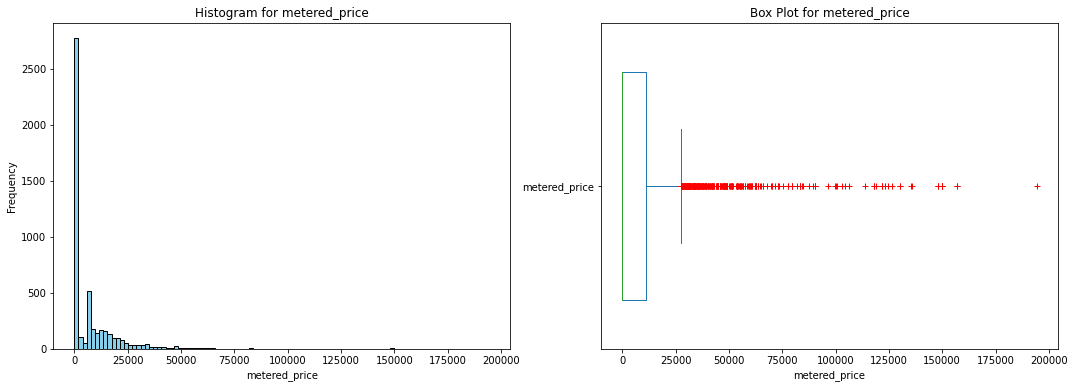

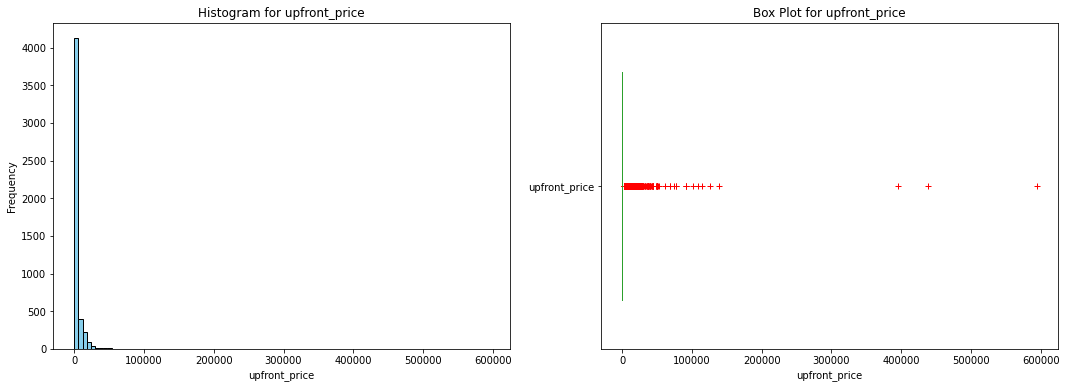

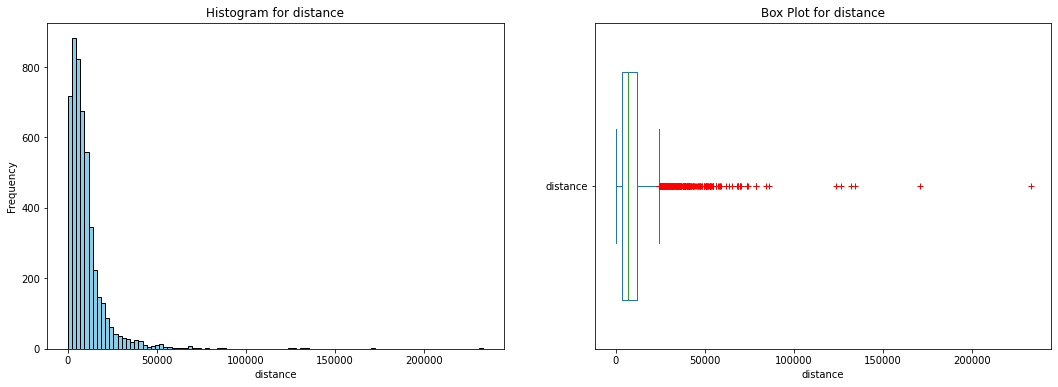

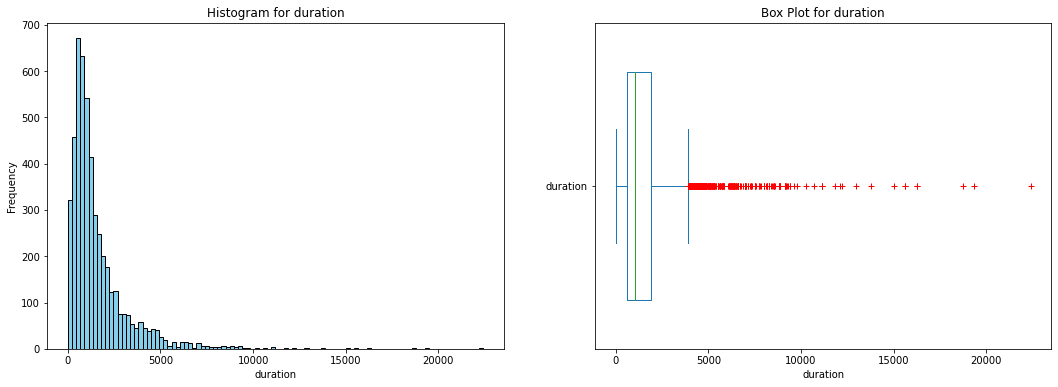

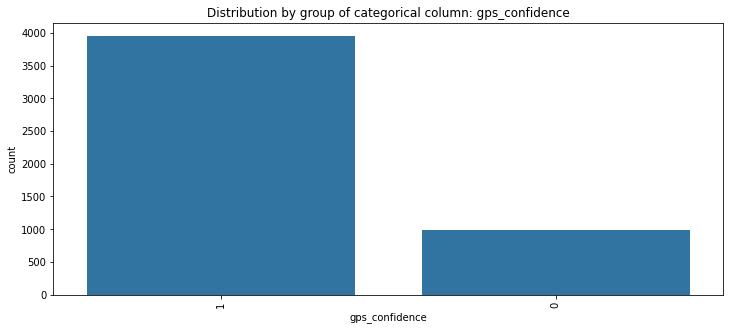

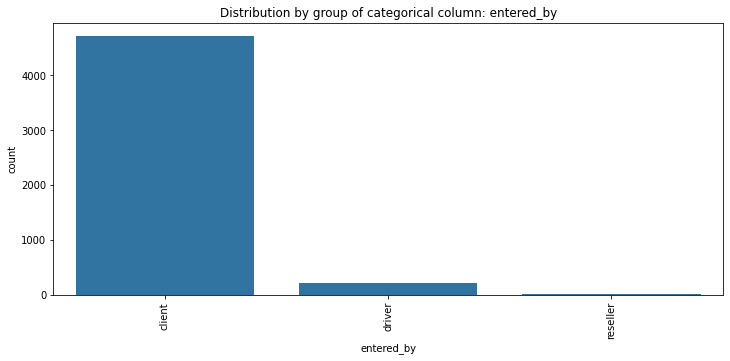

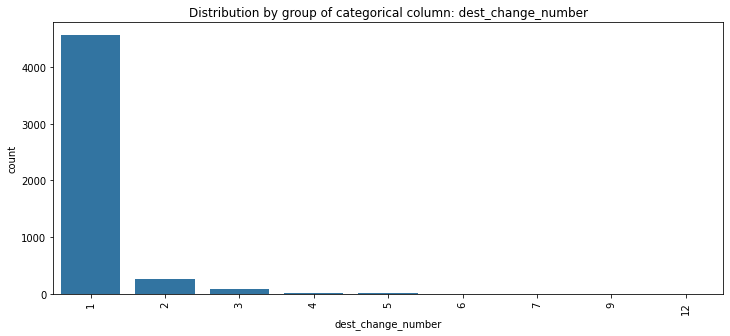

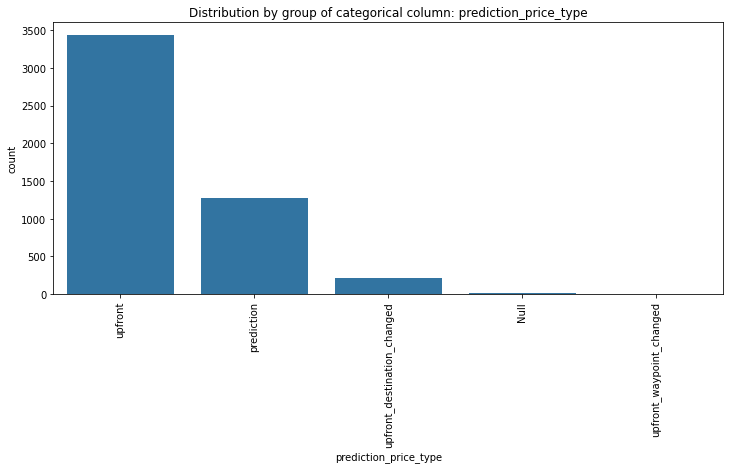

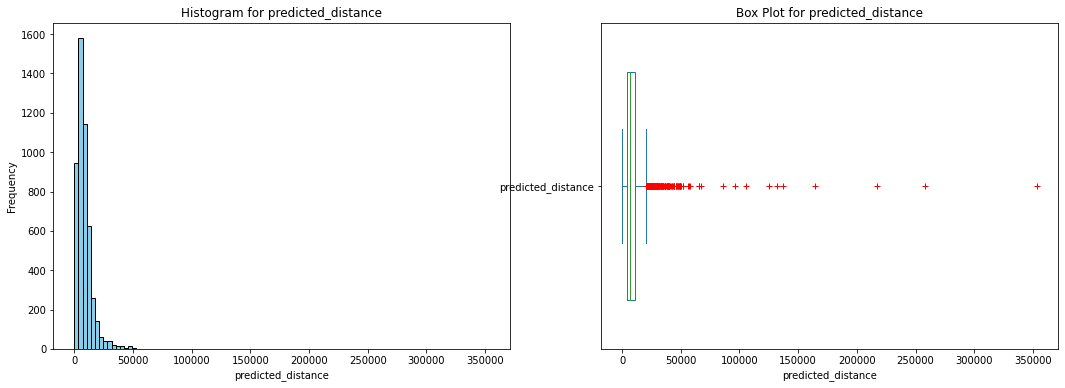

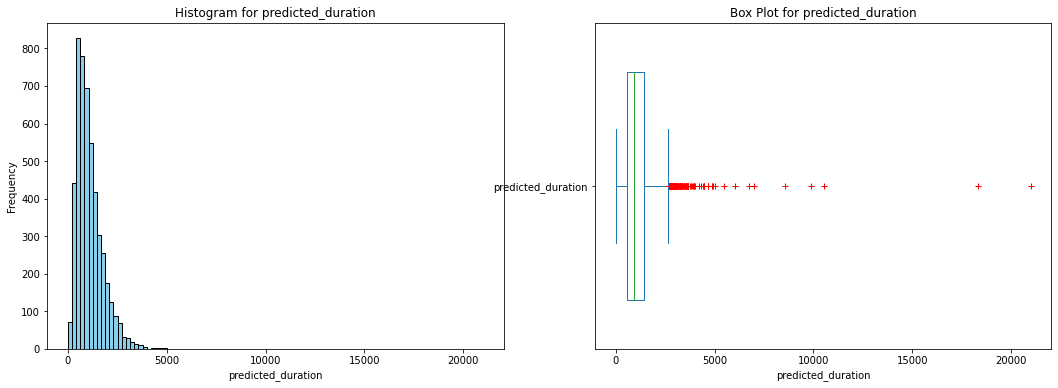

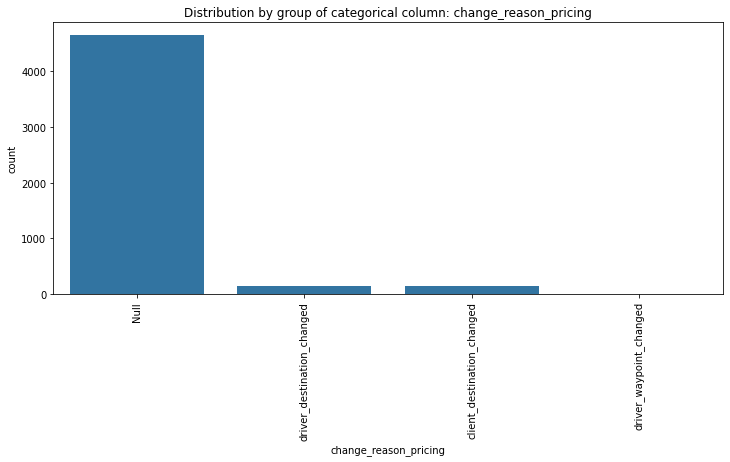

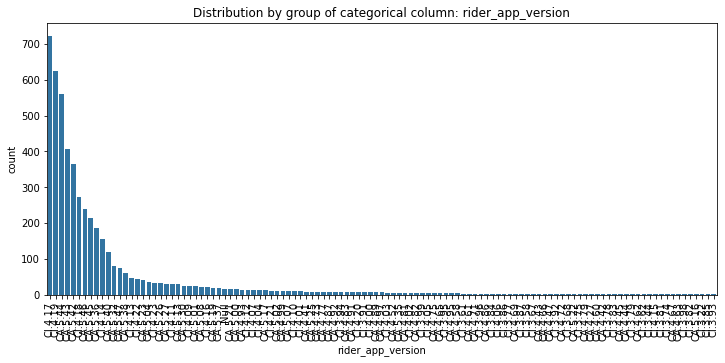

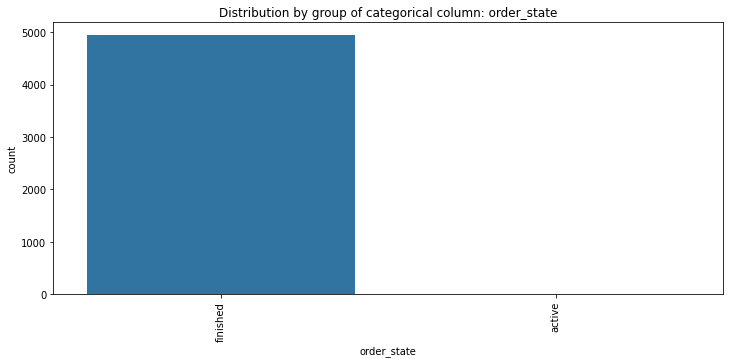

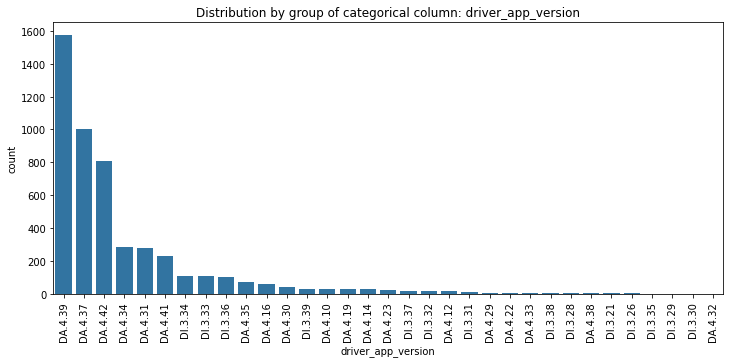

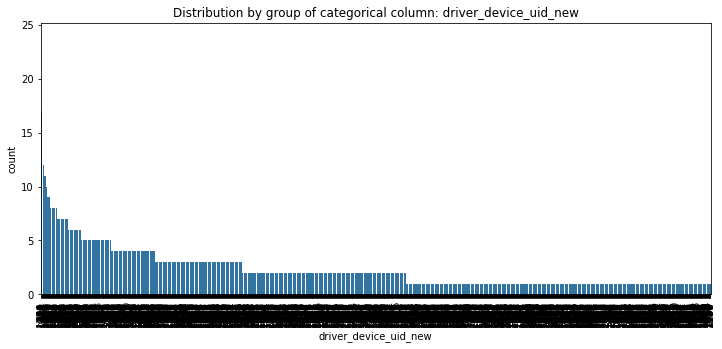

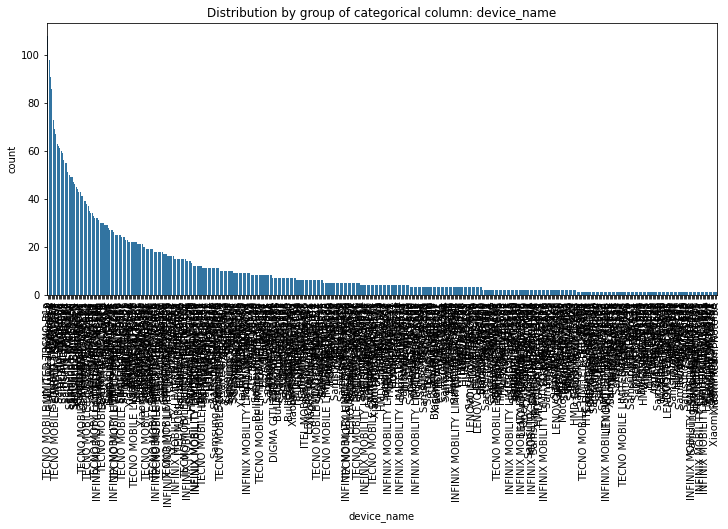

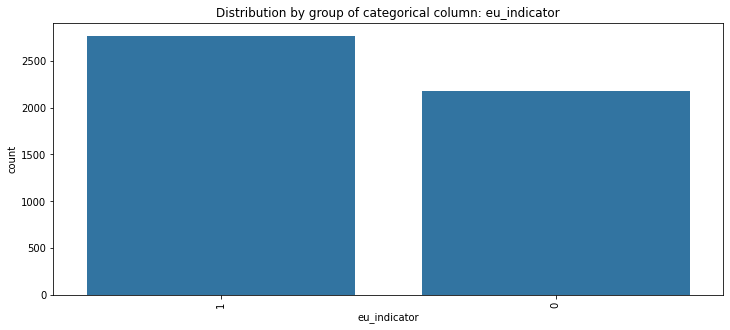

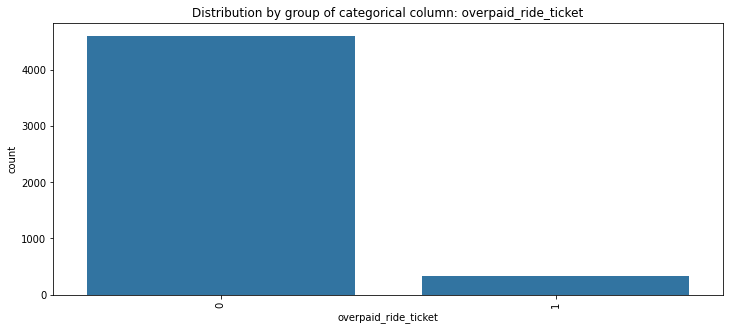

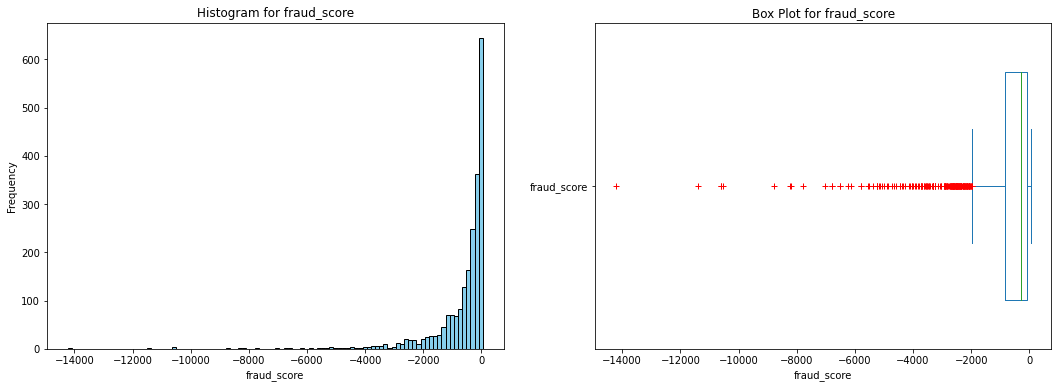

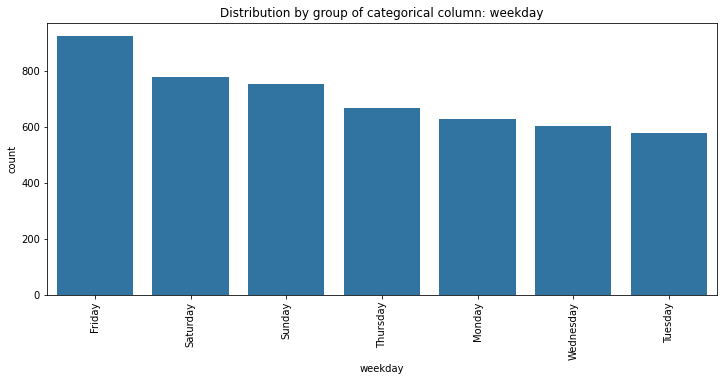

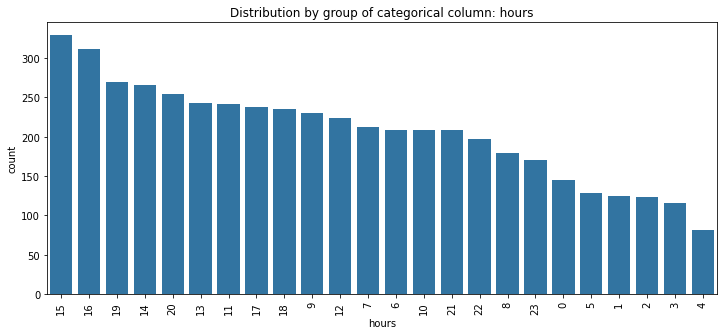

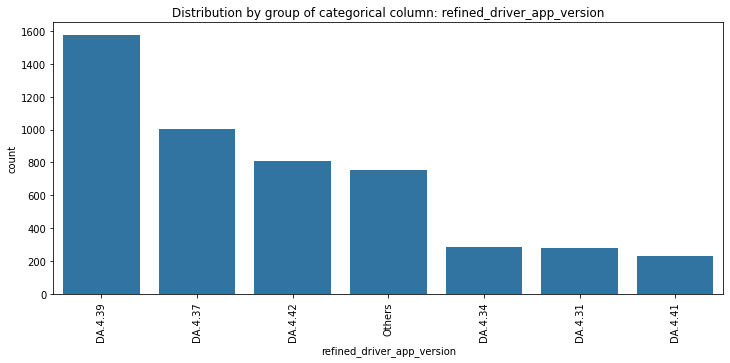

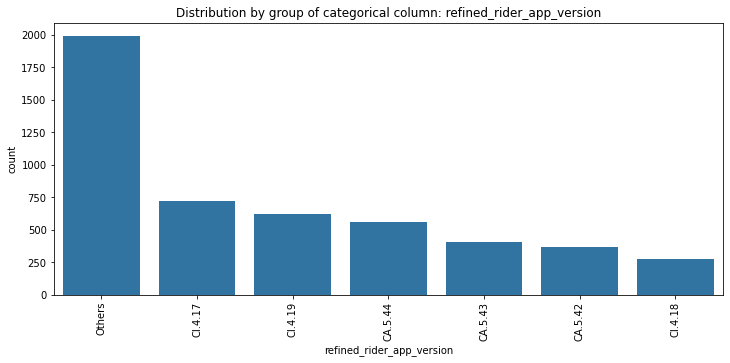

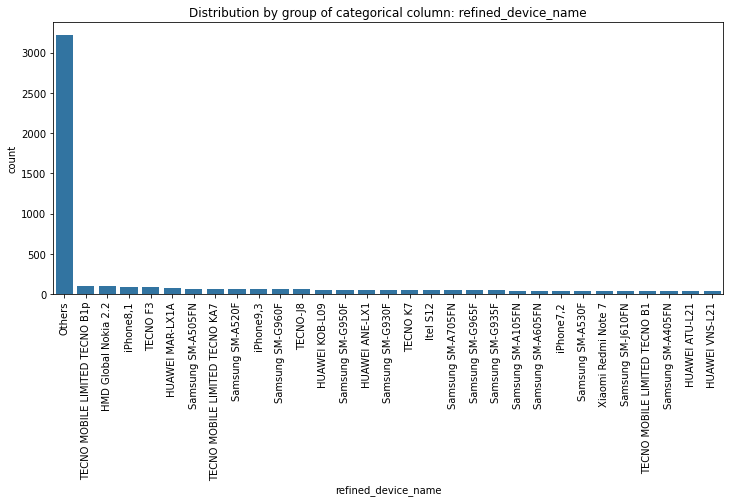

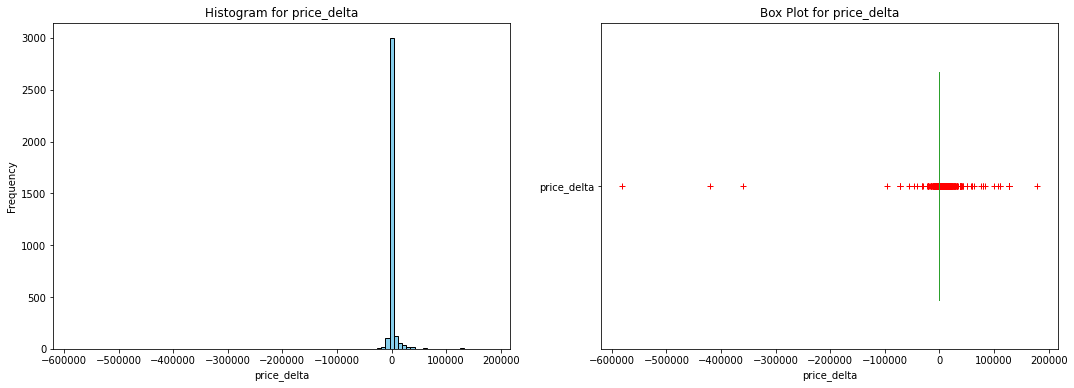

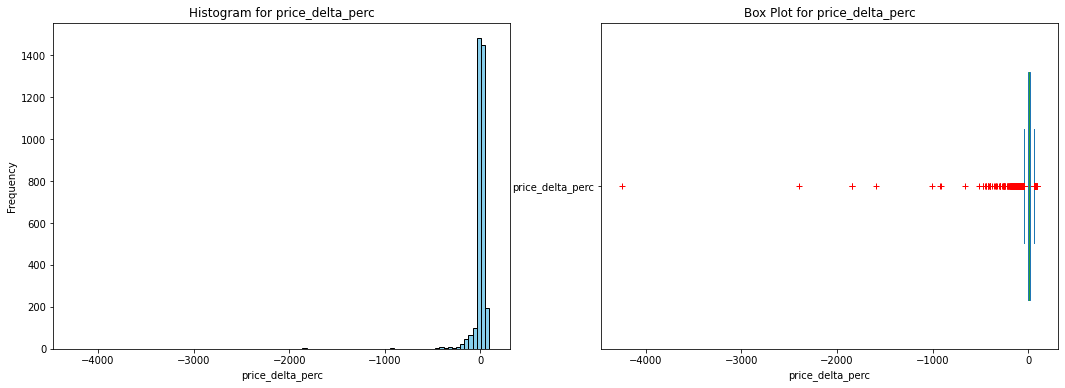

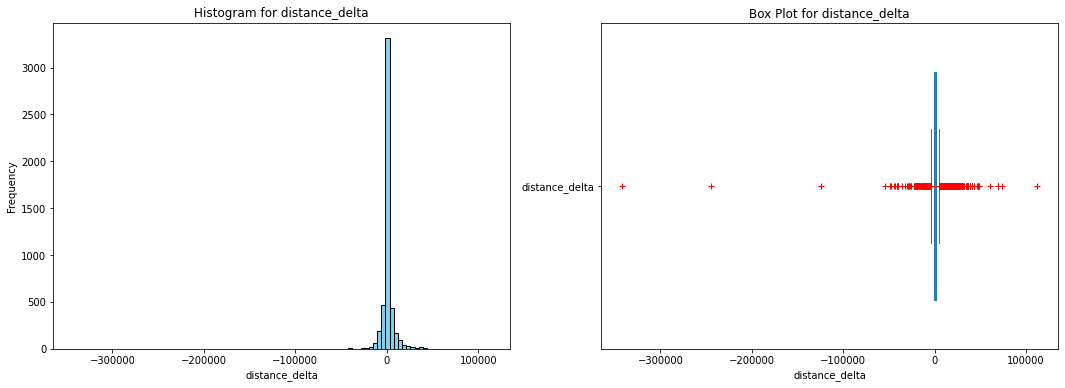

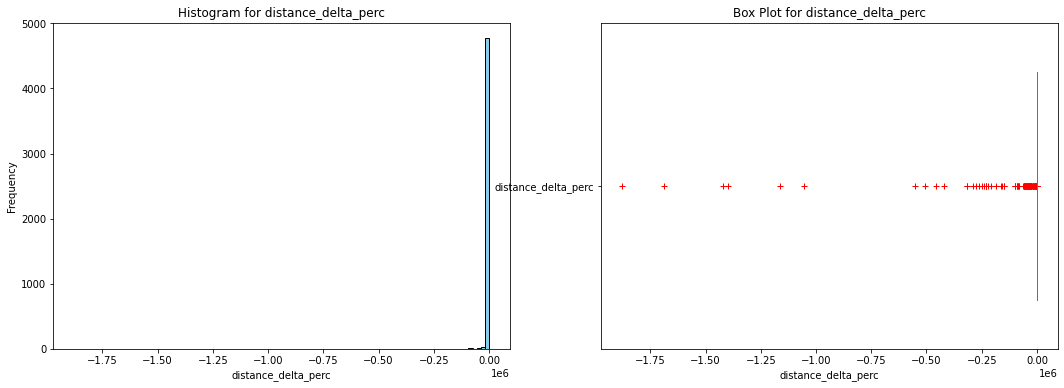

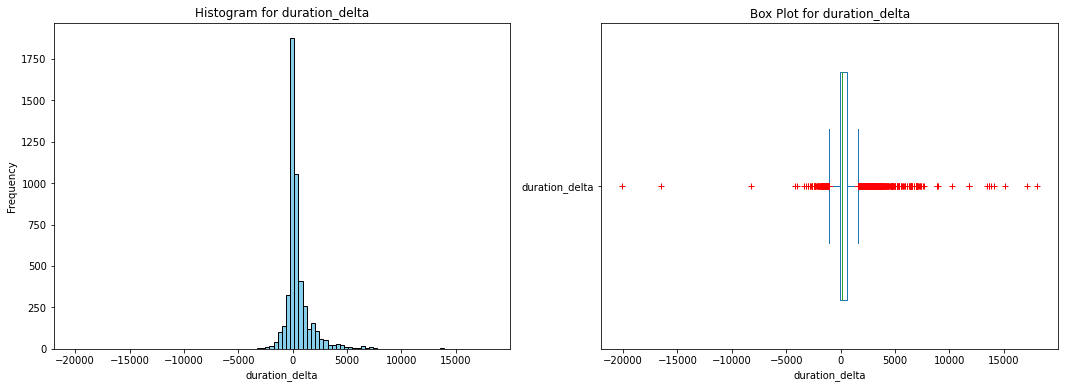

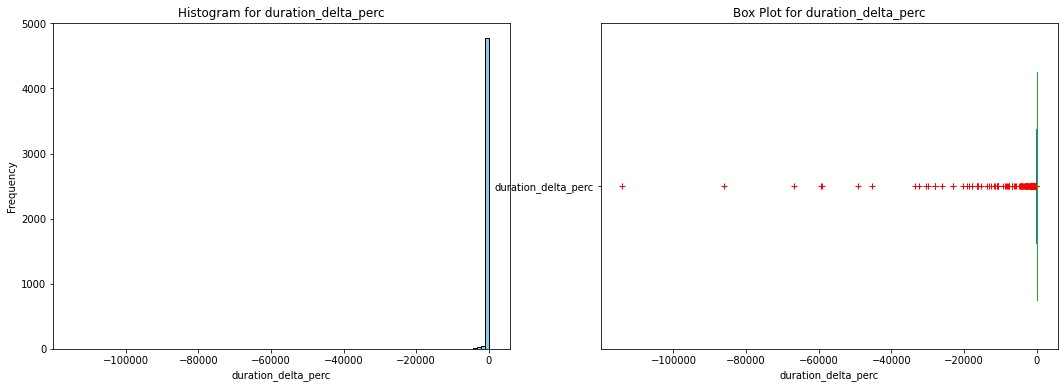

In [8]:
# Set the background color and style
# sns.set(style="darkgrid", rc={'mode.use_inf_as_null': True})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# Set the background to white and text color to black
plt.style.use('default')

columns_to_analyze = df.columns

for column in columns_to_analyze:
    if column in numeric_col:
        # Numerical column
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 2, 1)
        # Filter infinite values
        df_plot = df[df[column].abs() < np.inf].copy()
        if col in ["metered_price", "upfront_price", "distance", "duration"]:
            # Filtering the null values 
            df_plot = df_plot[df_plot[col] > -99]
        df_plot[column].plot(kind='hist', color='skyblue', edgecolor='k', bins=100)
        plt.title(f'Histogram for {column}')
        plt.xlabel(column)

        plt.subplot(1, 2, 2)
        df[column].plot(kind='box', vert=False, widths=0.7, sym='r+')
        plt.title(f'Box Plot for {column}')
        plt.xlabel(column)

    elif column in cat_col:
        # Categorical column
        df_plot = df.copy()
        plt.figure(figsize=(12, 5))
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
        plt.title(f'Distribution by group of categorical column: {column}', color='black')
        plt.xticks(rotation=90, color='black')
        plt.tick_params(axis='y', colors='black')  # Whitened yticks
        # plt.gca().set_facecolor('black')  # Set the background color to black
        plt.show()



## Correlation among numerical variables

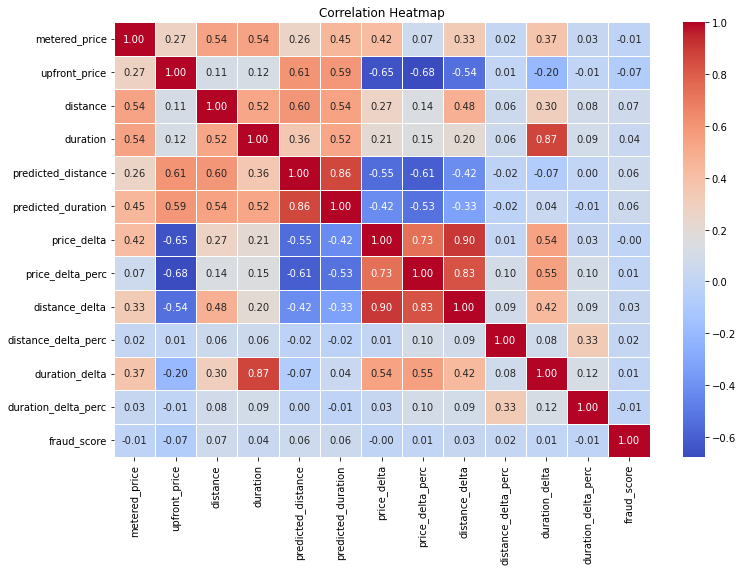

In [9]:
correlation_matrix = df[numeric_col].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

* Since upfront_price was predicted based on `predicted_distance` and `predicted_duration`, it's understandable price discrepancy (`price_delta_perc` ) has strong correlation with `distance` and `duration`
* `fraud_score`, on the other hands, seems not having any sign of correlation to other numeric variables

## Visualize all predicted variables vs. ground truth variables
* `upfront_price` vs `metered_price`
* `predicted_distance` vs `distance`
* `predicted_duration` vs `duration`
* When predicted values = ground truth values, we got the perfect prediction line

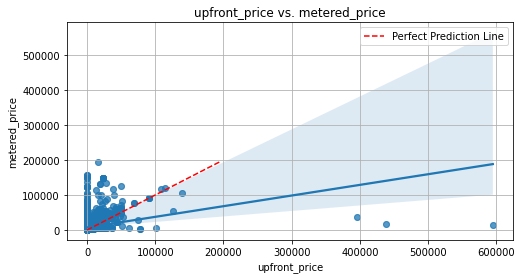

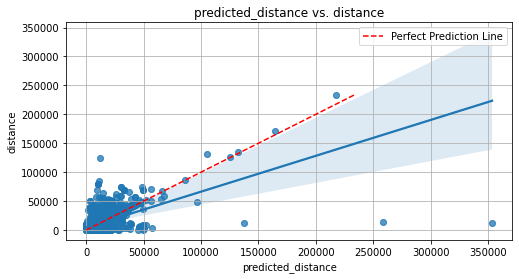

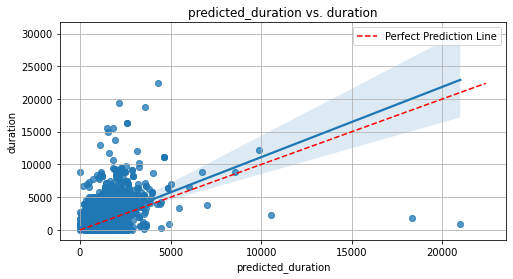

In [10]:
for(x, y) in [("upfront_price", "metered_price"),
              ("predicted_distance", "distance"),
              ("predicted_duration", "duration")]:


    plt.figure(figsize=(8,4))
    plt.scatter(df[x], df[y], alpha=0.5)
    sns.regplot(x=x, y=y, data=df, scatter_kws={'alpha':0.5})
    plt.plot([df[y].min(), df[y].max()], [df[y].min(), df[y].max()], linestyle='--', color='red', label='Perfect Prediction Line')
    plt.title(f"{x} vs. {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.show()

* As we can see, while the duration prediction did a fair job, the distance prediction is a challengable. Thus, the price prediction was being affected
* Improving distance prediction could be one of the key factors to improve the upfront pricing

## Analysis of Variance (ANOVA) among categorical variables

* We have target variable `price_delta_perc` (price discrepancy between metered and upfront values). For a considered categorical variable, ANOVA is used to test the difference among the means `price_delta_perc` of each group.
* Assume the critical value = 0.05. If ANOVA test returns p-value < 0.05, we could reject null hypothesis and claim there're difference in means of `price_delta_perc` among groups in a considered categorical variable. This means that considered categorical variable could be potentially ones of the factors which affect the precision of upfront pricing prediction
* We also wanna examine the `fraud_score` to see which factors can affect the rider fraud detector

In [11]:
alpha = 0.05
analyze_target_list = ["price_delta_perc", "fraud_score"]
for analyze_target in analyze_target_list:
    output = {}
    nan_rows = df[analyze_target].isna()
    select_df = df[~nan_rows]
    print(f"Samples dimension: {select_df.shape}")
    # Perform ANOVA for each categorical variable
    for column in cat_col:

        category_groups = []
        n_unique = select_df[column].nunique()
        if n_unique == 1 or 'id' in column:
            continue
        for category in select_df[column].unique():
            category_group = select_df[select_df[column] == category][analyze_target]
            category_groups.append(category_group)
        
        # Perform one-way ANOVA
        f_statistic, p_value = f_oneway(*category_groups)
        output[column] = [p_value]
        
    output = pd.DataFrame(output).T
    output.columns = ["p-value"]
    output = output.sort_values(by="p-value", ascending=True)
    print(f"List of categorical variables showing the difference among means of {analyze_target} in sub-groups")
    display(output[output["p-value"] < alpha])

Samples dimension: (3409, 38)
List of categorical variables showing the difference among means of price_delta_perc in sub-groups


,p-value
device_name,1.426178e-52
change_reason_pricing,2.486425e-49
dest_change_number,1.624797e-24
eu_indicator,7.261157e-07
refined_device_name,6.398917e-06
hours,4.098619e-02


Samples dimension: (2184, 38)
List of categorical variables showing the difference among means of fraud_score in sub-groups


,p-value
hours,0.000007
weekday,0.000321
entered_by,0.008189
refined_device_name,0.044318


* Since `change_reason_pricing` is empty most of the orders, we can observe that those variables shows the difference are: `device_name`, `dest_change_number` (although ~90% is 1 or no change), `eu_indicator` (location), and `hours`. This means those variables can play a role in upfront pricing prediction
* The test also shows that time (hours/weekday) or seasonality can indicate whether a ride is fraudulent or not

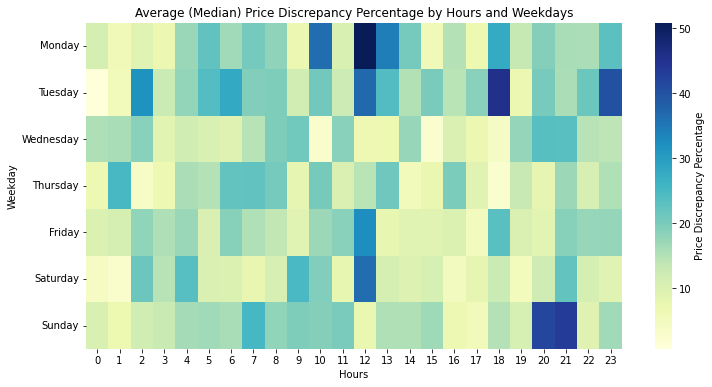

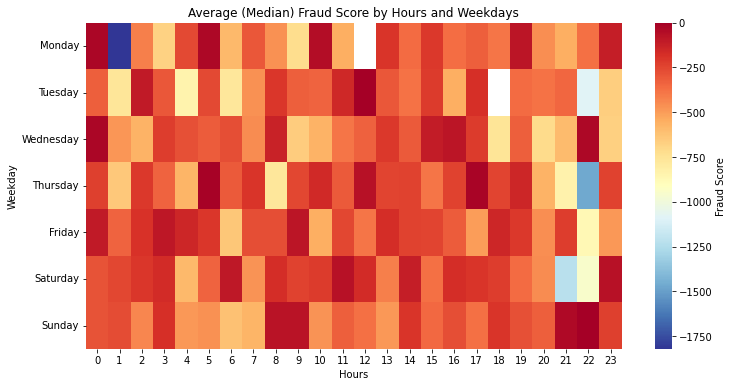

In [12]:
sorted_hours = list(range(24))

# Sort the weekdays in the desired order
sorted_weekdays = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]


selected_column_list = ['price_delta_perc', 'fraud_score']

for selected_column in selected_column_list:

    heatmap_df = df[["weekday", "hours", selected_column]]
    if selected_column == 'price_delta_perc':
        heatmap_df.loc[:, selected_column] = heatmap_df.loc[:, selected_column].abs()
    pivot_df = heatmap_df.pivot_table(index='weekday', columns='hours', values=selected_column, aggfunc='median').T.reset_index()
    pivot_df = pivot_df.sort_values(by="hours")
    pivot_df = pivot_df[sorted_weekdays].T
    
    plt.figure(figsize=(12, 6))
    label = 'Price Discrepancy Percentage' if selected_column == 'price_delta_perc' else 'Fraud Score'
    cmap='YlGnBu' if selected_column == 'price_delta_perc' else 'RdYlBu_r'
    title = 'Average (Median) Price Discrepancy Percentage by Hours and Weekdays' if selected_column == 'price_delta_perc' else 'Average (Median) Fraud Score by Hours and Weekdays'
    sns.heatmap(pivot_df, annot=False, cmap=cmap, cbar_kws={'label': label})
    
    # Customize the heatmap
    plt.title(title)
    plt.xlabel('Hours')
    plt.ylabel('Weekday')
    
    # Show the heatmap
    plt.show()

* We can observe some patterns of pricing inconsistency during lunch time of Monday, Tuesday, Friday and Saturday, especially Sunday from 8 - 10 pm, Tuesday evening 6-7 pm and after 11 pm
* 1-2 AM on Monday, 10-11 pm on Thursday and 9 -10 on Saturday are the times where riders are confidently legit.

Categorical Count (%)
gps_confidence
1    80.07283
0    19.92717
Name: count, dtype: float64


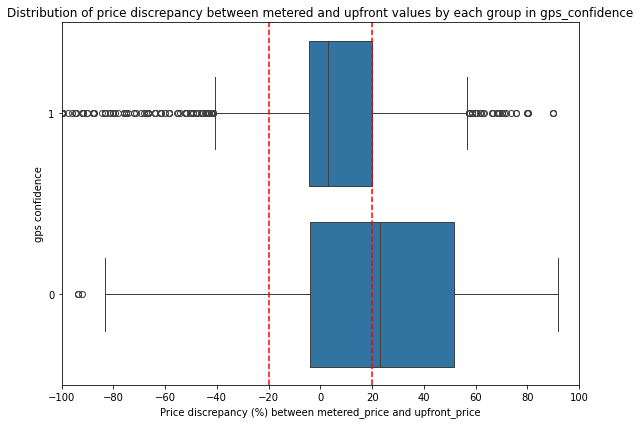

Categorical Count (%)
entered_by
client      95.529031
driver       4.369816
reseller     0.101153
Name: count, dtype: float64


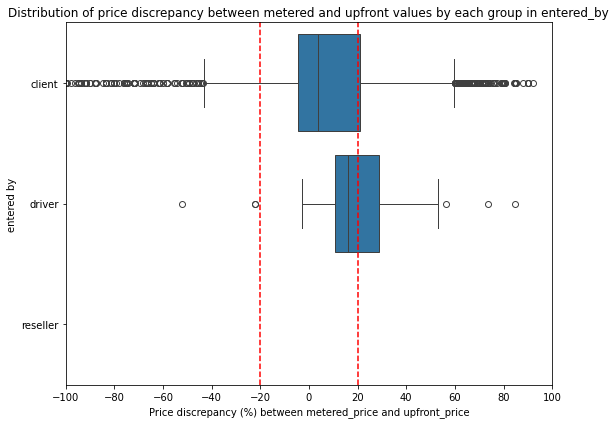

Categorical Count (%)
dest_change_number
1     92.150516
2      5.259964
3      1.800526
4      0.424843
5      0.242768
6      0.040461
7      0.040461
9      0.020231
12     0.020231
Name: count, dtype: float64


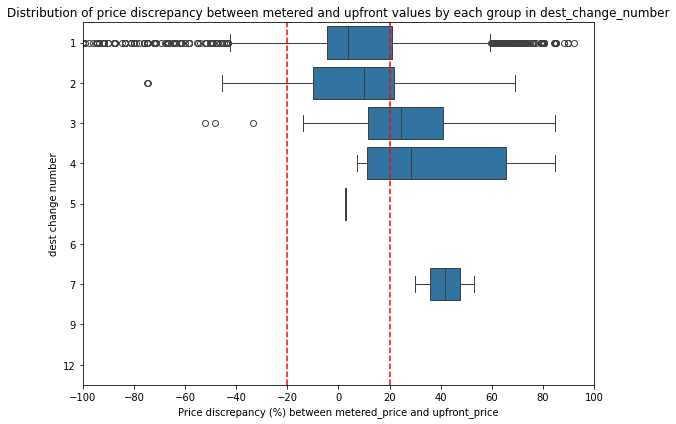

Categorical Count (%)
prediction_price_type
upfront                        69.431519
prediction                     25.874975
upfront_destination_changed     4.207971
Null                            0.404613
upfront_waypoint_changed        0.080923
Name: count, dtype: float64


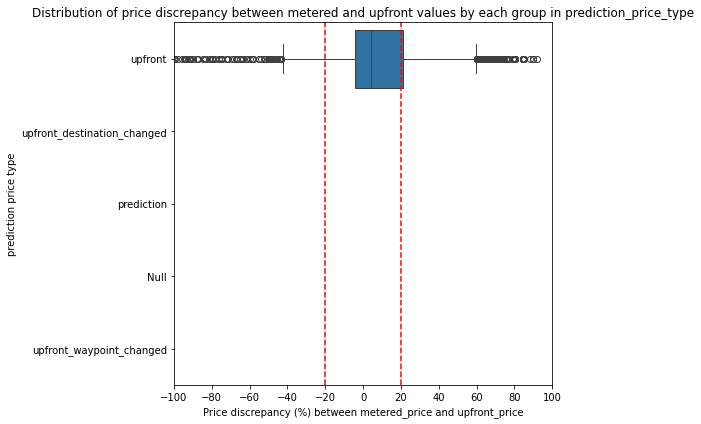

Categorical Count (%)
change_reason_pricing
Null                          93.971273
driver_destination_changed     3.034594
client_destination_changed     2.872749
driver_waypoint_changed        0.121384
Name: count, dtype: float64


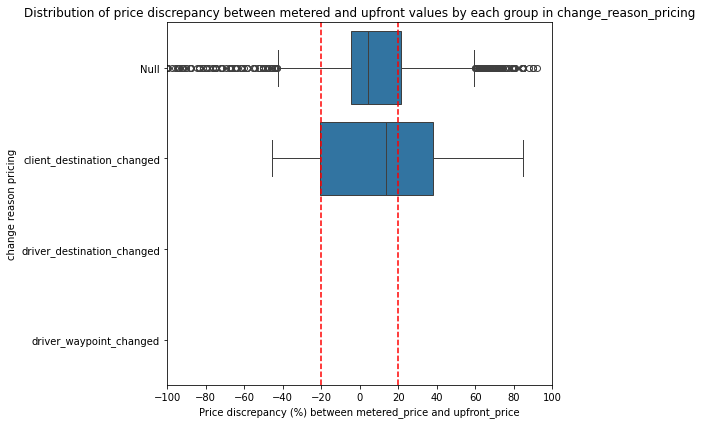

Categorical Count (%)
rider_app_version
CI.4.17    14.626745
CI.4.19    12.623913
CA.5.44    11.329152
CA.5.43     8.213635
CA.5.42     7.384180
             ...    
CI.3.82     0.020231
CA.5.16     0.020231
CI.3.22     0.020231
CI.3.85     0.020231
CI.3.93     0.020231
Name: count, Length: 115, dtype: float64


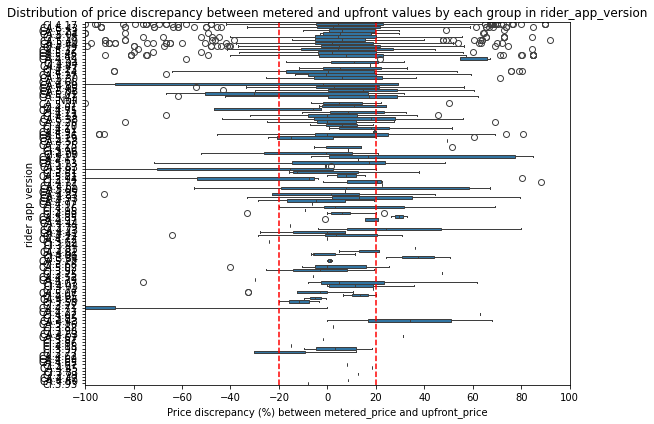

Categorical Count (%)
refined_rider_app_version
Others     40.319644
CI.4.17    14.626745
CI.4.19    12.623913
CA.5.44    11.329152
CA.5.43     8.213635
CA.5.42     7.384180
CI.4.18     5.502731
Name: count, dtype: float64


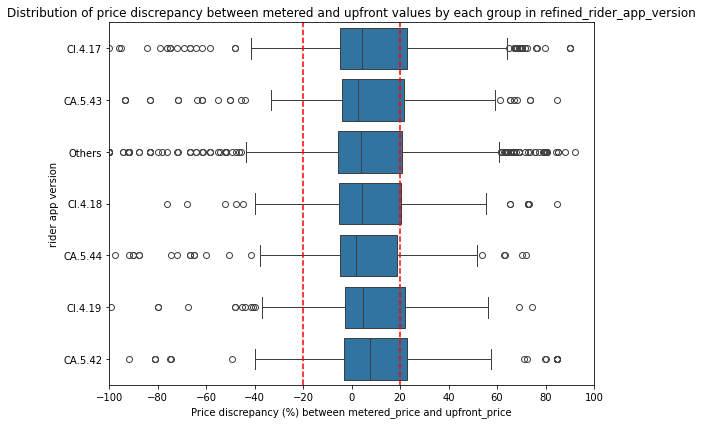

Categorical Count (%)
order_state
finished    99.979769
active       0.020231
Name: count, dtype: float64


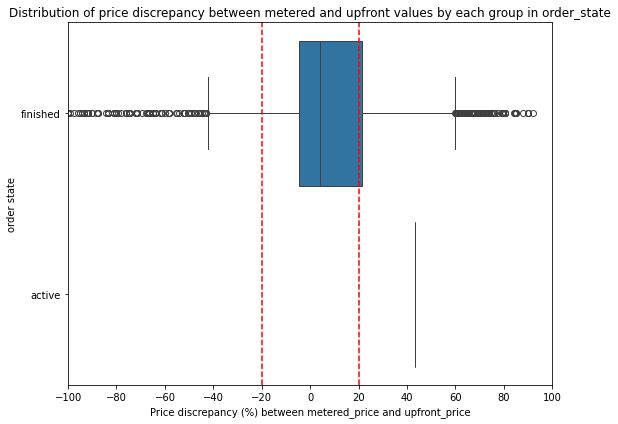

Categorical Count (%)
driver_app_version
DA.4.39    31.822780
DA.4.37    20.291321
DA.4.42    16.326118
DA.4.34     5.826421
DA.4.31     5.705037
DA.4.41     4.713737
DI.3.34     2.265830
DI.3.33     2.164677
DI.3.36     2.103985
DA.4.35     1.517297
DA.4.16     1.274530
DA.4.30     0.809225
DI.3.39     0.667611
DA.4.10     0.627150
DA.4.19     0.606919
DA.4.14     0.586688
DA.4.23     0.485535
DI.3.37     0.364151
DI.3.32     0.343921
DA.4.12     0.343921
DI.3.31     0.262998
DA.4.29     0.141614
DA.4.22     0.101153
DA.4.33     0.101153
DI.3.38     0.101153
DI.3.28     0.080923
DA.4.38     0.080923
DI.3.21     0.080923
DI.3.26     0.080923
DI.3.35     0.060692
DI.3.29     0.020231
DI.3.30     0.020231
DA.4.32     0.020231
Name: count, dtype: float64


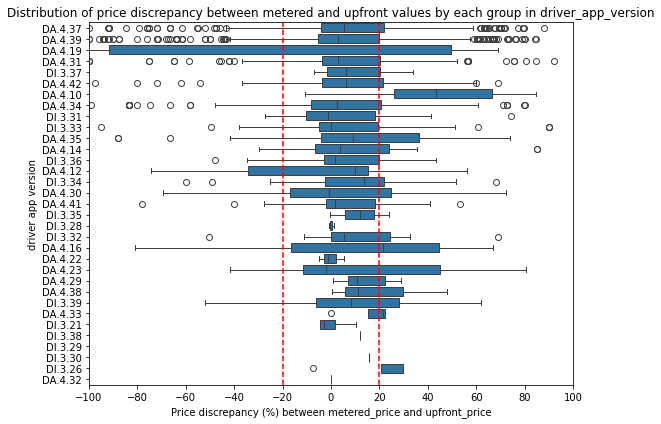

Categorical Count (%)
refined_driver_app_version
DA.4.39    31.822780
DA.4.37    20.291321
DA.4.42    16.326118
Others     15.314586
DA.4.34     5.826421
DA.4.31     5.705037
DA.4.41     4.713737
Name: count, dtype: float64


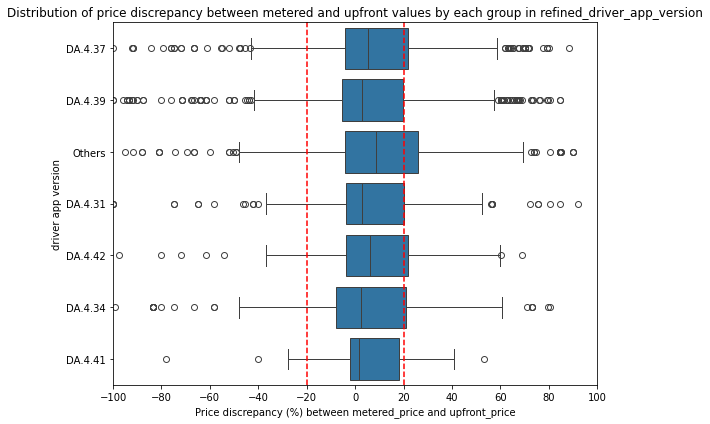

Categorical Count (%)
driver_device_uid_new
1776    0.485535
1145    0.343921
831     0.343921
1877    0.323690
859     0.262998
          ...   
2049    0.020231
1976    0.020231
1386    0.020231
1096    0.020231
688     0.020231
Name: count, Length: 2159, dtype: float64


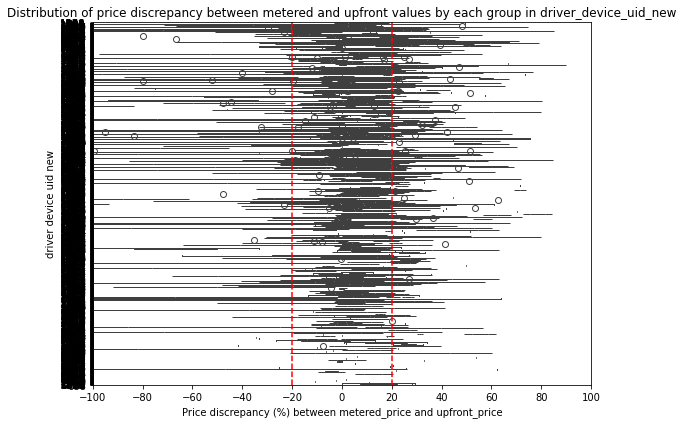

Categorical Count (%)
device_name
TECNO MOBILE LIMITED TECNO B1p    2.184908
HMD Global Nokia 2.2              1.982602
iPhone8,1                         1.840987
TECNO F3                          1.739834
HUAWEI MAR-LX1A                   1.476836
                                    ...   
Samsung SM-N920V                  0.020231
Samsung SM-G925T                  0.020231
Samsung SM-G925A                  0.020231
Xiaomi Redmi Note 5A Prime        0.020231
Xiaomi Redmi Note 5A              0.020231
Name: count, Length: 497, dtype: float64


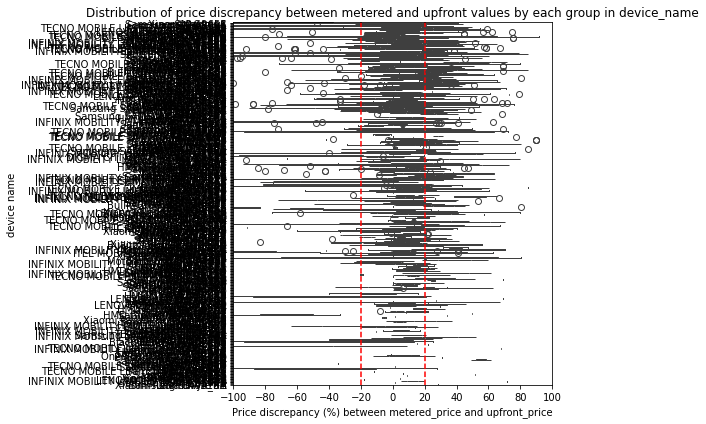

Categorical Count (%)
refined_device_name
Others                            65.041473
TECNO MOBILE LIMITED TECNO B1p     2.184908
HMD Global Nokia 2.2               1.982602
iPhone8,1                          1.840987
TECNO F3                           1.739834
HUAWEI MAR-LX1A                    1.476836
Samsung SM-A505FN                  1.395913
TECNO MOBILE LIMITED TECNO KA7     1.355452
Samsung SM-A520F                   1.274530
iPhone9,3                          1.254299
Samsung SM-G960F                   1.234068
TECNO-J8                           1.213838
HUAWEI KOB-L09                     1.193607
Samsung SM-G950F                   1.132915
HUAWEI ANE-LX1                     1.112685
Samsung SM-G930F                   1.112685
TECNO K7                           1.031762
Itel S12                           1.011531
Samsung SM-A705FN                  0.991301
Samsung SM-G965F                   0.991301
Samsung SM-G935F                   0.950840
Samsung SM-A105FN                 

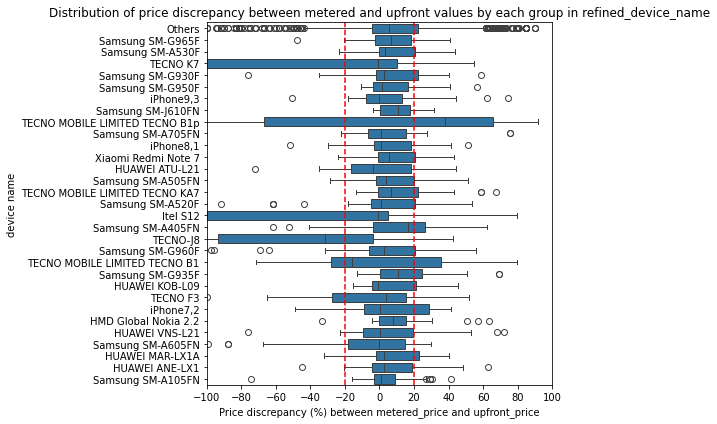

Categorical Count (%)
eu_indicator
1    56.038843
0    43.961157
Name: count, dtype: float64


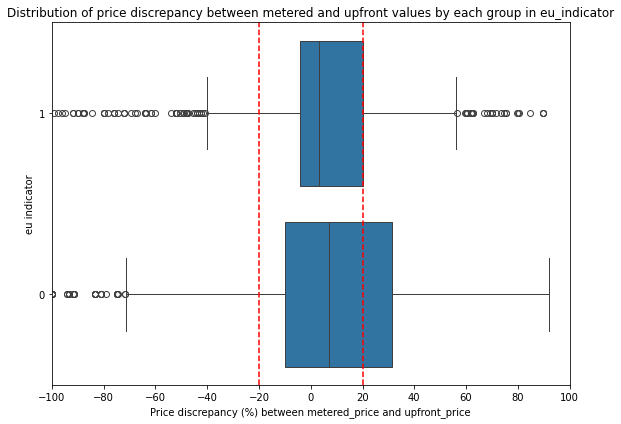

Categorical Count (%)
overpaid_ride_ticket
0    93.182278
1     6.817722
Name: count, dtype: float64


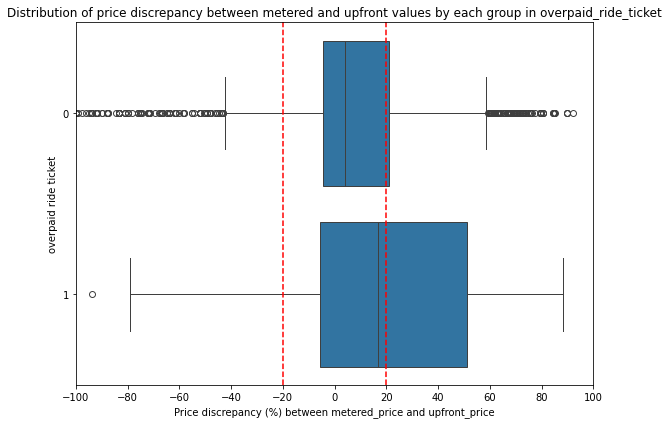

Categorical Count (%)
weekday
Friday       18.733563
Saturday     15.800121
Sunday       15.253894
Thursday     13.493830
Monday       12.765527
Wednesday    12.259761
Tuesday      11.693304
Name: count, dtype: float64


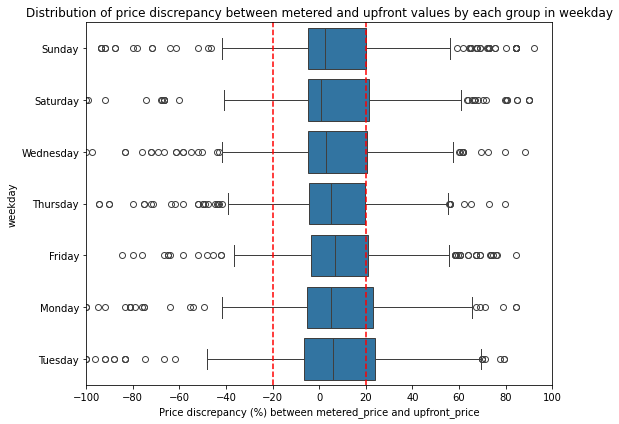

Categorical Count (%)
hours
15    6.655877
16    6.311956
19    5.462270
14    5.381347
20    5.138580
13    4.916043
11    4.895812
17    4.814890
18    4.754198
9     4.653045
12    4.531661
7     4.288893
6     4.207971
10    4.207971
21    4.207971
22    3.985434
8     3.621283
23    3.439207
0     2.933441
5     2.589521
1     2.508598
2     2.488367
3     2.346753
4     1.658912
Name: count, dtype: float64


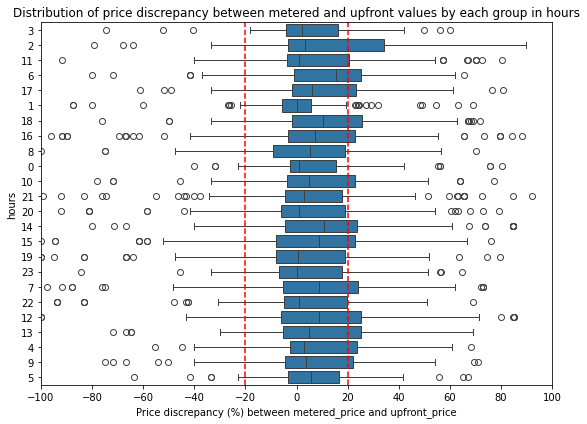

In [13]:
x_values=[-20, 20]
custom_x_ticks = [i for i in range(-100, 101, 20)]
for i, column in enumerate(cat_col):
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=column, x='price_delta_perc', data=df)
    plt.title(f'Distribution of price discrepancy between metered and upfront values by each group in {column}')
    plt.xlim([-100, 100])
    # Add vertical lines at x-values -20 and 20 within the specified x-axis limits
    # aceptable tolerance of pricing discrepancy
    for x in x_values:
        plt.axvline(x, color='red', linestyle='--')
    print("Categorical Count (%)")
    print(100*df[column].value_counts() / df[column].value_counts().sum())
    plt.xlabel('Price discrepancy (%) between metered_price and upfront_price')
    yname = column.split("_")
    yname = " ".join(yname[1:]) if yname[0] == "refined" else " ".join(yname)
    plt.ylabel(yname)
    ax = plt.gca()
    ax.set_xticks(custom_x_ticks)
    plt.tight_layout()
    plt.show()

* We can see the price discrepancy varies signficiantly based on GPS quality, driver app, device compatibility and location EU/non-EU
